In [1]:
import h5py

import pathlib
import re

import h5py
import imageio
import IPython.display as disp

import math
import numpy as np
import scipy

from scipy.interpolate import interp1d
from scipy.integrate import simps, quad

from astropy import constants as const
from astropy.modeling import models

from astropy import units as u

#%matplotlib ipympl
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
stellar_spectrum_orig = pathlib.Path("../input/") / "stellar_sample_orig.h5"





resampled_stellar_spectrum_path = pathlib.Path("../input/") / "stellar_spectrum.h5"

opacity_sample = pathlib.Path( "../input/opac_sample_r50.h5" )



In [3]:
# get wavelength bin centers
with h5py.File(opacity_sample, "r") as opac_h5:    
                        
    # wavelength grid                
    try:
        opac_wave = [x for x in opac_h5["center wavelengths"][:]]
    except KeyError:
        opac_wave = [x for x in opac_h5["wavelengths"][:]]
        nbin = len(opac_wave)
                    
                                       
    # interface positions of the wavelength bins
    try:
        opac_interwave = [i for i in opac_h5["interface wavelengths"][:]]
    except KeyError:
        # quick and dirty way to get the lamda interface values
        opac_interwave = []
        opac_interwave.append(opac_wave[0] - (opac_wave[1] - opac_wave[0])/2)
        for x in range(len(opac_wave) - 1):
            opac_interwave.append((opac_wave[x+1] + opac_wave[x])/2)
        opac_interwave.append(opac_wave[-1] + (opac_wave[-1] - opac_wave[-2])/2)

        # widths of the wavelength bins
        try:
            opac_deltawave = [w for w in opac_h5["wavelength width of bins"][:]]
        except KeyError:
            opac_deltawave = []
            for x in range(len(opac_interwave) - 1):
                opac_deltawave.append(opac_interwave[x + 1] - opac_interwave[x])
        


In [4]:
# get input wavelength and spectrum

def recursive_key_print(data, level=0):
    
    for k in data.keys():
        if type(data[k]) == h5py.Dataset:
                  
            print(level*" " +"* " + k)
        else:
            print(level*" " + "- " + k)
            recursive_key_print(data[k], level+1)

with h5py.File(stellar_spectrum_orig, "r") as spectrum_h5:
    # inspect a bit
    print("Keys:")
    recursive_key_print(spectrum_h5)
    
    
    # original spectrum    
    orig_spectrum_lambda = spectrum_h5['original']['phoenix']['lambda'][:]
    orig_spectrum_flux = spectrum_h5['original']['phoenix']['hd189733'][:]
    
    # helios spectrum    
    helios_spectrum_lambda = spectrum_h5['r50']['lambda'][:]
    helios_spectrum_flux = spectrum_h5['r50']['phoenix']['hd189733'][:]
    
    
    # rescale spectrum. Input is in erg*s^-1*cm^-3 we want J*s^-1*m^-3 -> W/m^3
    # conversion to W/m³
    # orig_spectrum_flux *= 1e-1

    # orig wavelength is in um
    #orig_spectrum_lambda *= 1e4


Keys:
- original
 - phoenix
  * hd189733
  * lambda
- r50
 * lambda
 - phoenix
  * hd189733


In [5]:
print(f"Original wavelength: min = {np.min(orig_spectrum_lambda)}, max = {np.max(orig_spectrum_lambda)}, num_samples: {orig_spectrum_lambda.shape}")

print(f"Opacities file wavelength: min = {np.min(opac_wave)}, max = {np.max(opac_wave)}, num_samples: {len(opac_wave)}")

Original wavelength: min = 5e-06, max = 0.0005499975, num_samples: (1569128,)
Opacities file wavelength: min = 3.4000000000000007e-05, max = 0.019986383866080454, num_samples: 323


In [6]:
# plot original spectrum 

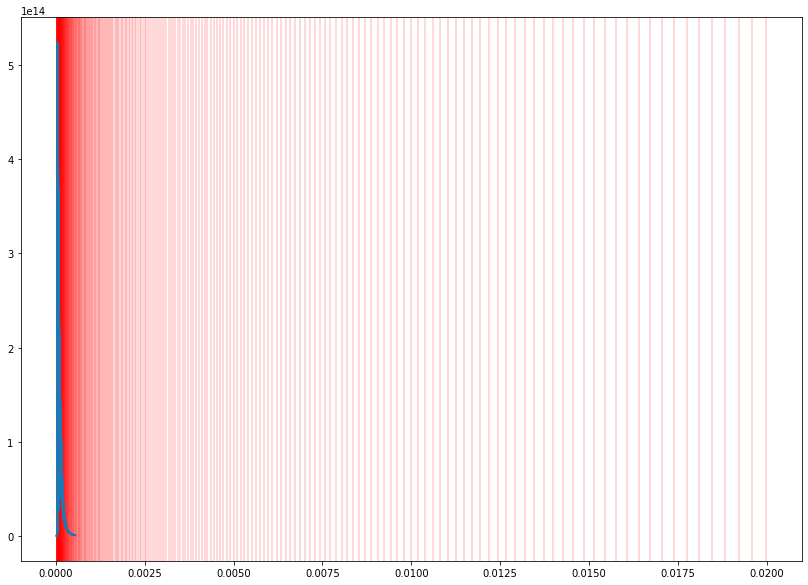

In [7]:
fig, ax = plt.subplots(1,1, figsize=(14,10))



for l in opac_wave:
    ax.axvline(l, c='r', alpha=0.2)
    
ax.plot(orig_spectrum_lambda, orig_spectrum_flux)

#ax.set_xscale('log')

In [8]:

C = const.c.cgs.value                   # speed of light in cm / s
K_B = const.k_B.cgs.value               # Boltzmann constant in erg / K
H = const.h.cgs.value                   # Planck constant in erg s



def calc_planck(lamda, temp):
    """ calculates the Planckian blackbody function at a given wavelength and temperature """

    term1 = 2 * H * C**2 / lamda**5

    term2 = np.exp(H * C / (lamda * K_B * temp)) - 1

    result = term1 * 1 / term2

    return result

In [9]:
def integrand(x): 
    return calc_planck(x, 4875)


int_planck = []
int_planck_lambda = []

#lambda_table = orig_spectrum_lambda
lambda_table = opac_interwave

l_start = opac_interwave[0]

for i, l_end in opac_interwave[1:]:
    #print(quad(integrand, l_start, l_end)[0])
    
    int_planck.append(quad(integrand, l_start, l_end)[0]/(l_end-l_start)*math.pi )
    
    int_planck_lambda.append( (l_start+l_end)/2.0)
    
    l_start = l_end
    

TypeError: cannot unpack non-iterable numpy.float64 object

ValueError: x and y must have same first dimension, but have shapes (323,) and (0,)

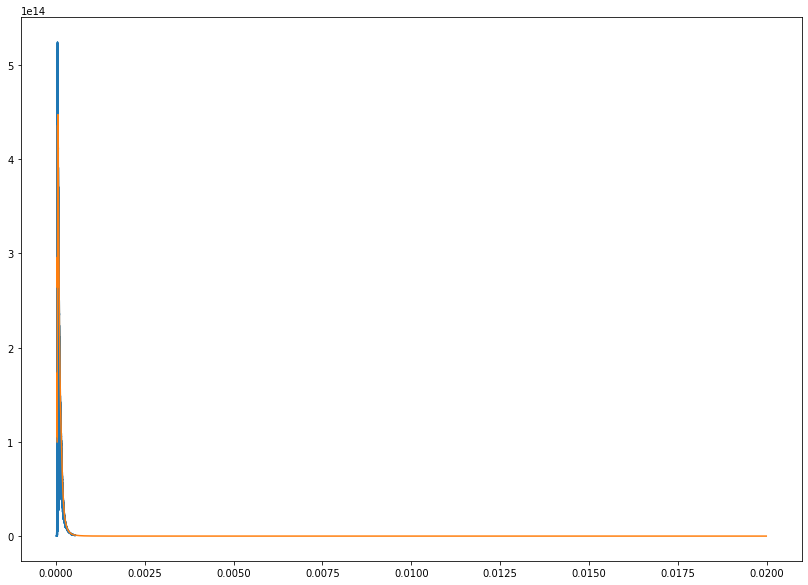

In [10]:

fig, ax = plt.subplots(1,1, figsize=(14,10))

ax.plot(orig_spectrum_lambda, orig_spectrum_flux)
ax.plot(helios_spectrum_lambda, helios_spectrum_flux)

plank = calc_planck(helios_spectrum_lambda, 4875)


ax.plot(opac_wave, int_planck, label="integrated planck function")

ax.plot(helios_spectrum_lambda, plank, label="planck law" )

ax.set_xscale('log')

#ax.set_xlim(1e-3, 1e-2)
#ax.set_ylim(-1e11, 1e11)

ax.legend()

(-10000000000.0, 10000000000.0)

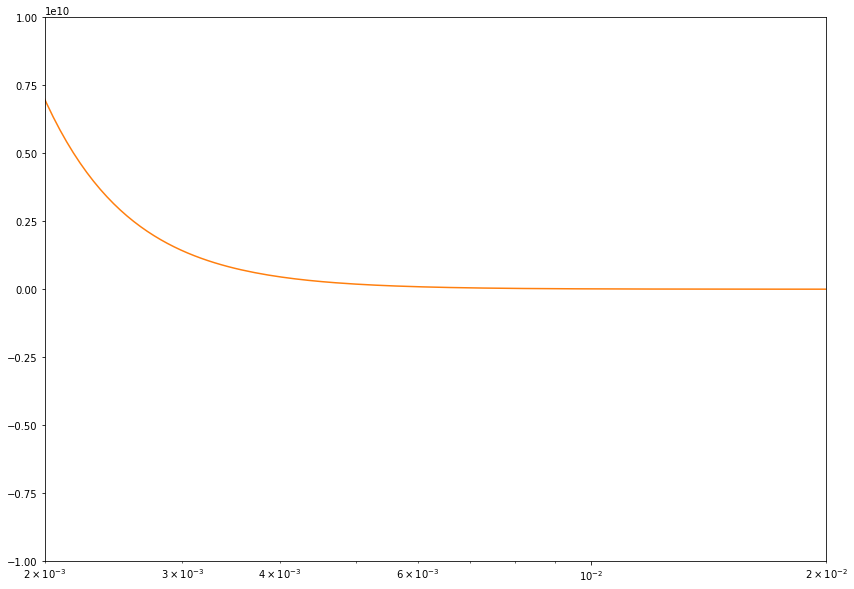

In [11]:
fig, ax = plt.subplots(1,1, figsize=(14,10))


    
ax.plot(orig_spectrum_lambda, orig_spectrum_flux)
ax.plot(helios_spectrum_lambda, helios_spectrum_flux)

ax.set_xscale('log')

ax.set_xlim(2e-3, 2e-2)
ax.set_ylim(-1e10, 1e10)

In [12]:
# interpolate spectrum

spectrum_interpolator = interp1d(orig_spectrum_lambda, 
                                 orig_spectrum_flux, 
                                 bounds_error=False,
                                 fill_value=(orig_spectrum_flux[-1], orig_spectrum_flux[0]) )

spectrum_new_flux = spectrum_interpolator(opac_wave)


(2e-05, 0.0002)

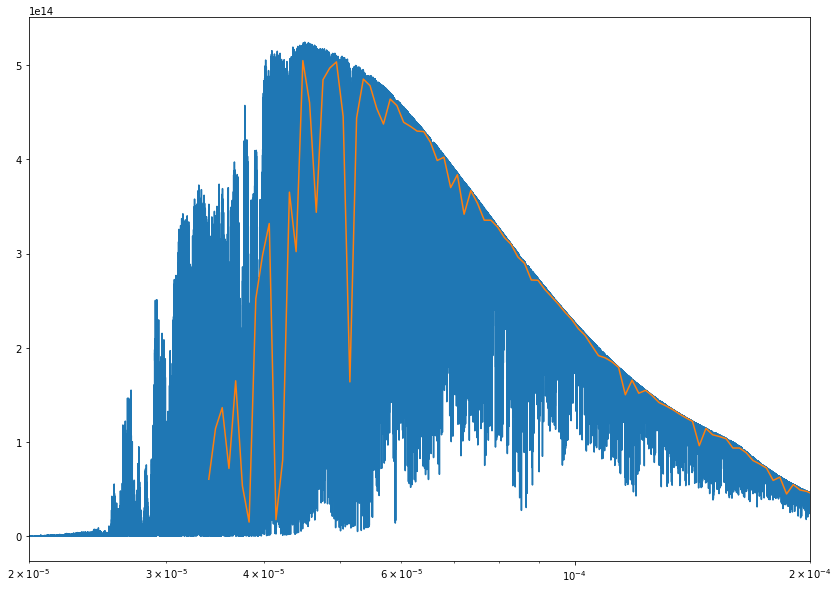

In [13]:
fig, ax = plt.subplots(1,1, figsize=(14,10))


    
ax.plot(orig_spectrum_lambda, orig_spectrum_flux)
ax.plot(opac_wave, spectrum_new_flux)

ax.set_xscale('log')

ax.set_xlim(2e-5, 2e-4)

In [14]:
# integrate spectrum in bins

l_start = opac_interwave[0]

intg = []

# avoid the last points that look funny in the spectrum
buf = 20

for l_end in opac_interwave[1:]:
    integrate_idx_start = np.searchsorted(orig_spectrum_lambda[:-buf], l_start, side='right')
    integrate_idx_stop = np.searchsorted(orig_spectrum_lambda[:-buf], l_end, side='left')
    if integrate_idx_start == integrate_idx_stop or integrate_idx_stop >= len(orig_spectrum_lambda[:-buf]):
        intg.append(quad(integrand, l_start, l_end)[0]/(l_end-l_start)*math.pi)
    else:
        x_s = orig_spectrum_lambda[integrate_idx_start:integrate_idx_stop]
        y_s = orig_spectrum_flux[integrate_idx_start:integrate_idx_stop]
    
        # interpolate end points
        x_s[0] = l_start
        x_s[-1] = l_end
        y_s[0] = spectrum_interpolator(l_start)
        y_s[-1] = spectrum_interpolator(l_end)
    
        # integrate
    
        integral = simps(y_s, x_s)
        intg.append(integral/(l_end - l_start))
    
    l_start = l_end


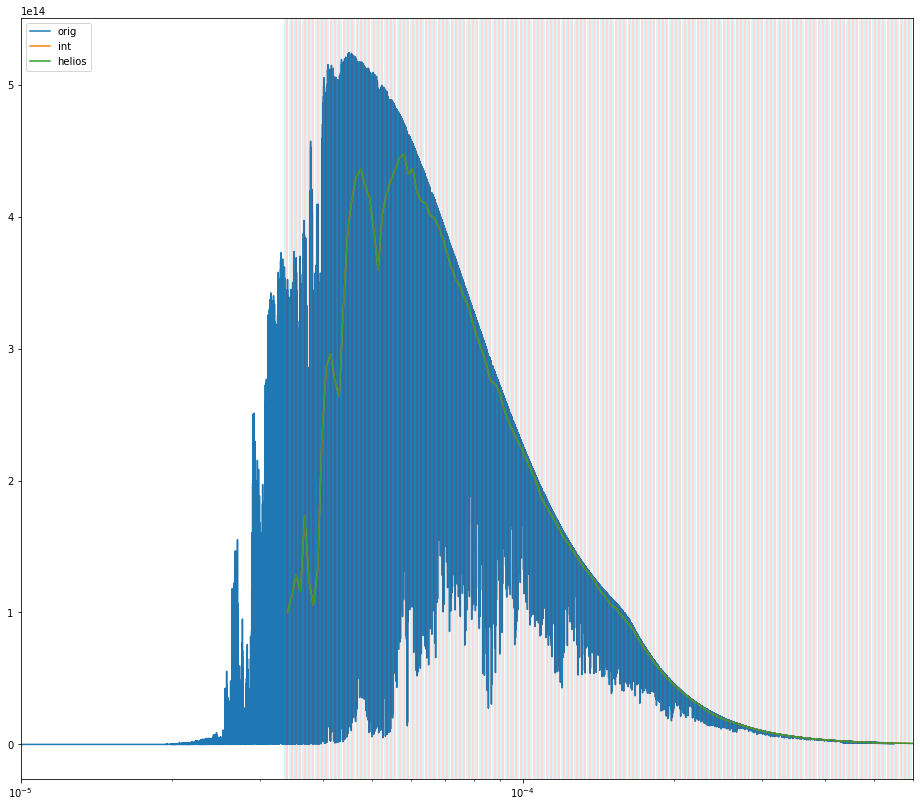

In [19]:
fig, ax = plt.subplots(1,1, figsize=(16,14))


b = -20
    
ax.plot(orig_spectrum_lambda[:b], orig_spectrum_flux[:b], label="orig")
ax.plot(opac_wave, intg, label="int")
ax.plot(helios_spectrum_lambda, helios_spectrum_flux, label="helios")
ax.set_xscale('log')

ax.set_xlim(1e-5, 0.6e-3)

for l in opac_wave:
    ax.axvline(l, c='r', alpha=0.2)
    
for l in opac_interwave:
    ax.axvline(l, c='c', alpha=0.2)

l = 8e14
#ax.set_ylim(-l, l)

ax.legend()

In [16]:
with h5py.File(resampled_stellar_spectrum_path, "w") as f:
    lambda_dset = f.create_dataset("wavelength", (len(opac_wave),), dtype=np.float64)
    flux_dset = f.create_dataset("flux", spectrum_new_flux.shape, dtype=np.float64)
    lambda_dset[...] = opac_wave
    flux_dset[...] = spectrum_new_flux

In [17]:
#p_toa = 1e-4
#p_boa = 1e6
#nlayer = 100

#press_levels = [p_boa * (p_toa/p_boa)**(i/(2 * nlayer - 1)) for i in range(2 * nlayer)]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(14,10))


    
ax.plot(orig_spectrum_lambda[1:] - orig_spectrum_lambda[:-1])


ax.set_yscale('log')




In [ ]:
orig_spectrum_lambda

In [ ]:
len(opac_wave)